🧠📊 SHAP Explainability

✅ Using large sample size for high-res plots: 50,000


100%|===================| 49826/50000 [02:00<00:00]        

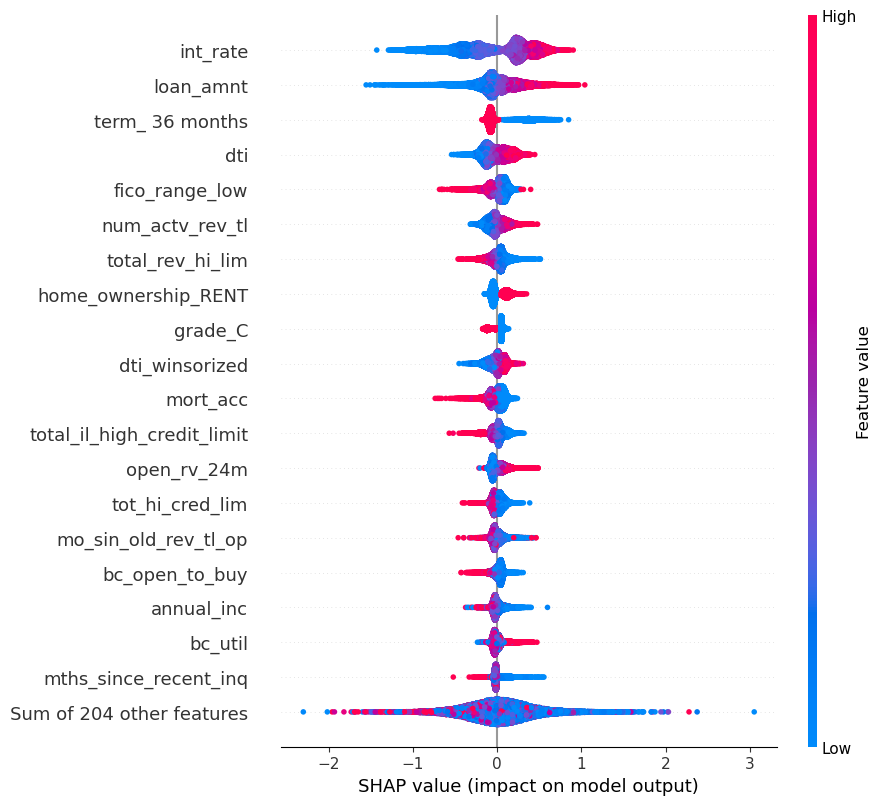

C:\Users\Alain\AppData\Local\Temp\ipykernel_34264\2234697168.py:98: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Alain\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


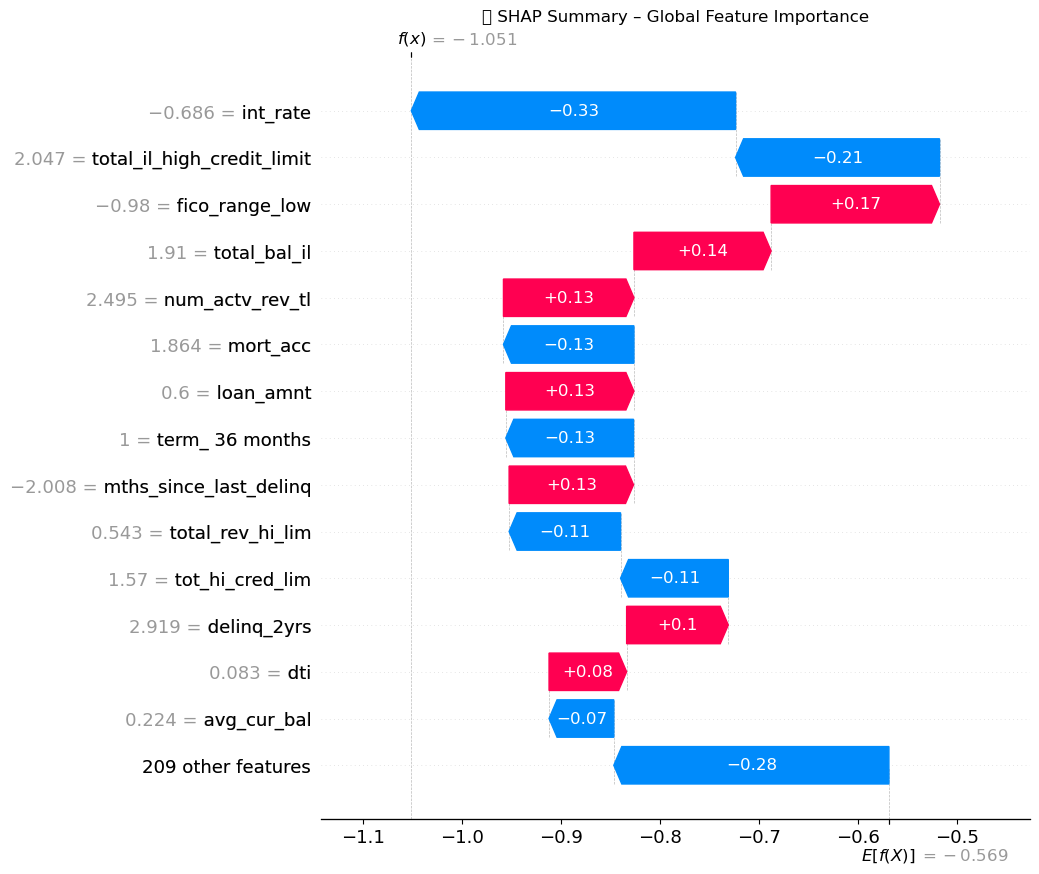

⚠️ No fallback interaction feature found. Plotting without interaction.


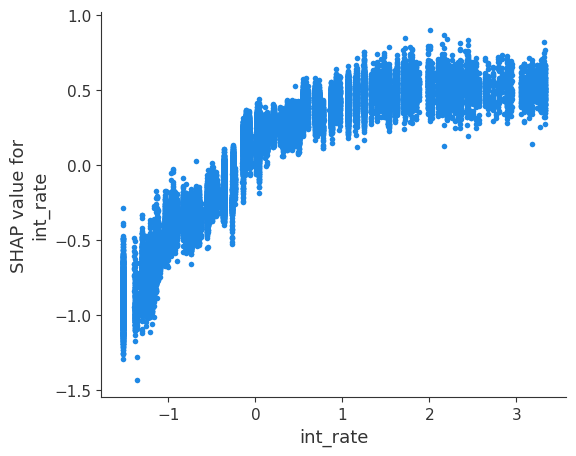

c:\Users\Alain\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


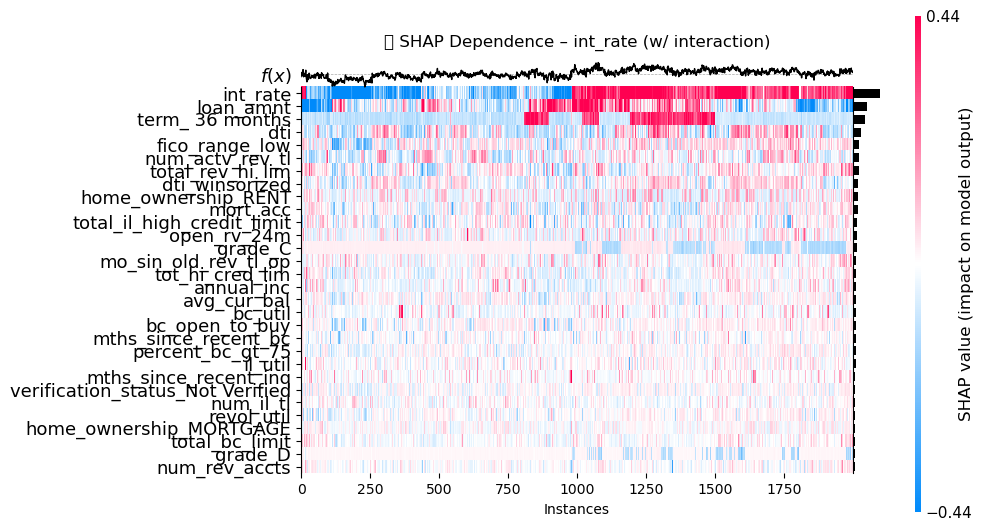

✅ Exported sampled SHAP explanations to: c:\Users\Alain\OneDrive\Desktop\Alain\Code Projects\borrowiq\notebooks\data\model_outputs\shap_explanations_sampled.csv


In [3]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from joblib import load
import psutil
import numpy as np
from pathlib import Path

# ===========================
# 🔺 PATH SETUP (Robust for both script + notebook)
# ===========================

try:
    # 📜 Script mode
    root_dir = Path(__file__).resolve().parents[1]
except NameError:
    # 📓 Notebook mode
    root_dir = Path.cwd()

data_dir = root_dir / "data" / "model_outputs"
data_dir.mkdir(parents=True, exist_ok=True)

model_path = data_dir / "xgb_pipeline_model.pkl"
x_test_path = data_dir / "X_test_transformed.csv"
y_test_path = data_dir / "y_test.csv"
y_proba_path = data_dir / "y_ensemble_proba.csv"
shap_out_path = data_dir / "shap_explanations_sampled.csv"

# ===========================
# 📥 LOAD DATA + MODEL
# ===========================

# Check for existence before loading
assert model_path.exists(), f"❌ Model file not found: {model_path}"
assert x_test_path.exists(), f"❌ X_test file not found: {x_test_path}"
assert y_test_path.exists(), f"❌ y_test file not found: {y_test_path}"
assert y_proba_path.exists(), f"❌ y_proba file not found: {y_proba_path}"

xgb_pipeline = load(model_path)
X_test_transformed = pd.read_csv(x_test_path)
y_test = pd.read_csv(y_test_path).squeeze()
y_ensemble_proba = pd.read_csv(y_proba_path).squeeze()

# ===========================
# 🔍 EXTRACT MODEL FROM PIPELINE
# ===========================

xgb_model = None
for step in xgb_pipeline.named_steps.values():
    if isinstance(step, CalibratedClassifierCV):
        xgb_model = step.base_estimator_
        break
    elif isinstance(step, XGBClassifier):
        xgb_model = step
        break
if xgb_model is None:
    raise ValueError("❌ XGBClassifier not found in pipeline.")

# ===========================
# 🔄 SAMPLE STRATEGY (RAM-AWARE)
# ===========================

if psutil.virtual_memory().available > 10e9:
    large_sample_size = 50000
    print("✅ Using large sample size for high-res plots: 50,000")
else:
    large_sample_size = 2000
    print("⚠️ Limited RAM – using fallback sample size: 2,000")

small_sample_size = 2000

X_large = X_test_transformed.sample(n=large_sample_size, random_state=42)
y_large = y_test.loc[X_large.index].reset_index(drop=True)
proba_large = y_ensemble_proba.loc[X_large.index].reset_index(drop=True)

X_small = X_test_transformed.sample(n=small_sample_size, random_state=123)
y_small = y_test.loc[X_small.index].reset_index(drop=True)
proba_small = y_ensemble_proba.loc[X_small.index].reset_index(drop=True)

# ===========================
# ⚡ FAST SHAP CALCULATIONS
# ===========================

explainer_large = shap.Explainer(xgb_model, X_large)
shap_values_large = explainer_large(X_large)

explainer_small = shap.Explainer(xgb_model, X_small)
shap_values_small = explainer_small(X_small)

# ===========================
# 📊 SHAP VISUALIZATIONS
# ===========================

shap.plots.beeswarm(shap_values_large, max_display=20)
plt.title("🧠 SHAP Summary – Global Feature Importance")
plt.tight_layout()

shap.plots.waterfall(shap_values_small[0], max_display=15)

# ✅ Safe fallback for interaction feature
dep_feature = "int_rate"
fallback_feature = "grade" if "grade" in X_large.columns else None
if fallback_feature is None:
    interaction_index = None
    print("⚠️ No fallback interaction feature found. Plotting without interaction.")
else:
    interaction_index = fallback_feature
    print(f"ℹ️ Using fallback interaction feature: {interaction_index}")

shap.dependence_plot(dep_feature, shap_values_large.values, X_large, interaction_index=interaction_index)
plt.title(f"📉 SHAP Dependence – {dep_feature} (w/ interaction)")

mean_abs_shap = np.abs(shap_values_small.values).mean(axis=0)
top_idx = np.argsort(mean_abs_shap)[::-1][:30]
shap.plots.heatmap(shap_values_small[:, top_idx], max_display=30)

# ===========================
# 💾 EXPORT EXPLANATIONS
# ===========================

shap_df = pd.DataFrame(shap_values_small.values, columns=X_small.columns)
shap_df['prediction'] = proba_small
shap_df['true_label'] = y_small
shap_df.to_csv(shap_out_path, index=False)

print(f"✅ Exported sampled SHAP explanations to: {shap_out_path}")
